In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
# import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smformula
import cartopy.crs as ccrs
import pymc3 as pm

/home/sbm/miniconda3/envs/deltaoxfox/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
coretop_path = './data_parsed/coretops-2017-09-27.csv'

In [4]:
coretops_raw = pd.read_csv(coretop_path)

coretops_raw.sort_values('species', inplace=True)
coretops = coretops_raw.query('temp_ann > 0').copy()

# MCMC

In [5]:
n_species = len(coretops['species'].unique())
idx_species = pd.Categorical(coretops['species']).codes

## Linear model, no seawater isotopes

In [18]:

with pm.Model() as model0:

    # Hyperparameters
    mu_a = pm.Normal('mu_alpha', mu=0, sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)

    mu_b = pm.Normal('mu_beta', mu=0, sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)

    # Intercept and slope
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_species)
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=n_species)
    # Model error
    eps = pm.HalfCauchy('eps', beta=1, shape=n_species)

    # Likelihood
    d18oc_est = a[idx_species] + b[idx_species] * coretops['temp_ann']
    likelihood = pm.Normal('y', mu=d18oc_est, sd=eps[idx_species], 
                           observed=coretops['d18oc'])

    trace0 = pm.sample(5000, njobs=1)


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 935.56:  20%|█▉        | 39400/200000 [00:41<03:43, 717.21it/s]   
Convergence archived at 39400
Interrupted at 39,400 [19%]: Average Loss = 9,030.9
100%|█████████▉| 5499/5500 [04:34<00:00, 17.98it/s]/home/sbm/miniconda3/envs/deltaoxfox/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 53 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5500/5500 [04:34<00:00, 20.02it/s]


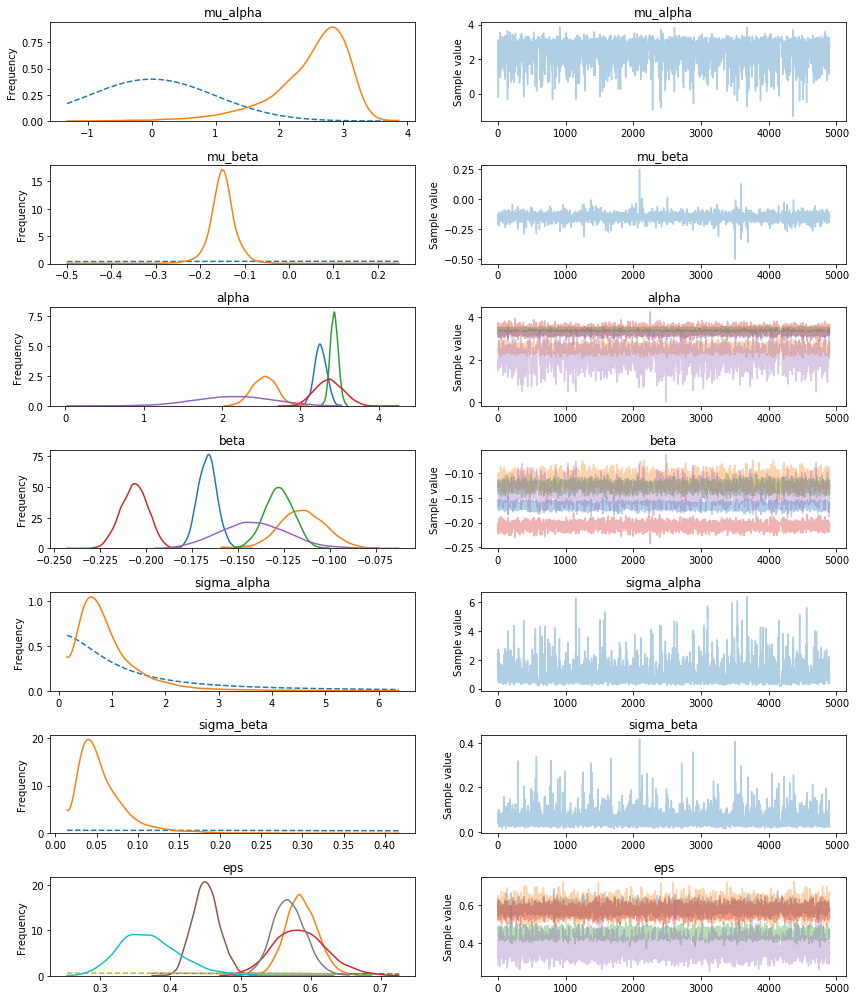

In [19]:
pm.traceplot(trace0[100:], priors=[mu_a.distribution, mu_b.distribution,
                                   None, None,
                                   sigma_a.distribution, sigma_b.distribution,
                                   eps.distribution])
plt.tight_layout()

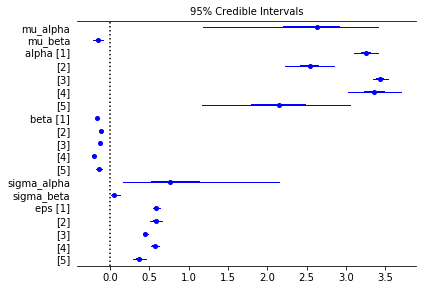

In [20]:
pm.forestplot(trace0)

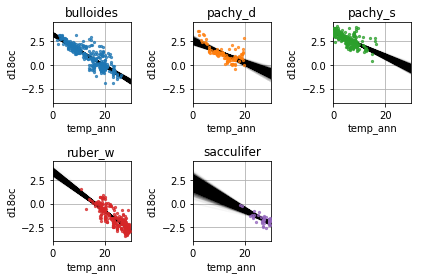

In [23]:
# Plot the simulations of fits for each spp.
synth_temp = np.arange(0, 31)
for i in np.unique(idx_species):
    spp = coretops.species.unique()[i]
    ax = plt.subplot(2, 3, i+1)
    spp_msk = coretops.species.unique() == spp
    y = trace0['alpha'][:, spp_msk] + trace0['beta'][:, spp_msk] * synth_temp
    ax.plot(np.broadcast_to(synth_temp, (y.shape[0], len(synth_temp))).T, 
            y.T, alpha = 0.01, label=spp, 
            color='black')
    coretops.query("species == '{}'".format(spp)).plot(y='d18oc', x='temp_ann', 
        ax=ax, kind='scatter', marker='.', alpha=0.75, 
        color=list(matplotlib.colors.TABLEAU_COLORS.values())[i], zorder=10)
    ax.set_xlim(0, 30)
    ax.set_ylim(-4, 4.5)
    ax.set_title(spp)
    ax.grid(True)
plt.tight_layout()
plt.show()

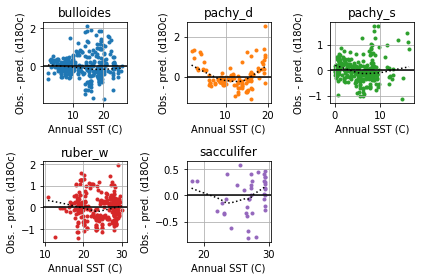

In [24]:
# Plot residuals of the median model for each spp.
for i in np.unique(idx_species):
    spp = coretops.species.unique()[i]
    coretops_sub = coretops.query("species == '{}'".format(spp))
    ax = plt.subplot(2, 3, i+1)
    spp_msk = coretops.species.unique() == spp
    alpha = np.median(trace0['alpha'][:, spp_msk])
    beta = np.median(trace0['beta'][:, spp_msk])
    y = alpha + beta * coretops_sub['temp_ann']
    resids = coretops_sub['d18oc'] - y
    resids_smoothed = sm.nonparametric.lowess(resids, coretops_sub['temp_ann'], frac=0.75)
    ax.plot(resids_smoothed[:, 0], resids_smoothed[:, 1], label='LOWESS', linestyle=':', color='black')

    ax.scatter(x=coretops_sub['temp_ann'], y=resids, marker='.', label=spp, 
               color=list(matplotlib.colors.TABLEAU_COLORS.values())[i])
    ax.axhline(y=0, color='black')
    ax.set_title(spp)
    ax.set_ylabel('Obs. - pred. (d18Oc)')
    ax.set_xlabel('Annual SST (C)')
    ax.grid(True)
plt.tight_layout()
plt.show()

## Quadratic model, no isotopes

In [6]:

with pm.Model() as model0:

    # Hyperparameters
    mu_a = pm.Normal('mu_alpha', mu=0, sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)

    mu_b = pm.Normal('mu_beta', mu=0, sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)

    mu_c = pm.Normal('mu_chi', mu=0, sd=1)
    sigma_c = pm.HalfCauchy('sigma_chi', beta=1)
    
    # Intercept and slope
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_species)
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=n_species)
    c = pm.Normal('chi', mu=mu_c, sd=sigma_c, shape=n_species)
    # Model error
    eps = pm.HalfCauchy('eps', beta=1, shape=n_species)

    # Likelihood
    d18oc_est = a[idx_species] + b[idx_species] * coretops['temp_ann'] + c[idx_species] * coretops['temp_ann']**2
    likelihood = pm.Normal('y', mu=d18oc_est, sd=eps[idx_species], 
                           observed=coretops['d18oc'])

    trace0 = pm.sample(5000, njobs=1)


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 1,002.8:  27%|██▋       | 53345/200000 [01:04<02:43, 898.94it/s]  
Convergence archived at 53400
Interrupted at 53,400 [26%]: Average Loss = 2.4004e+06
100%|██████████| 5500/5500 [20:31<00:00,  3.44it/s]/home/sbm/miniconda3/envs/deltaoxfox/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 162 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



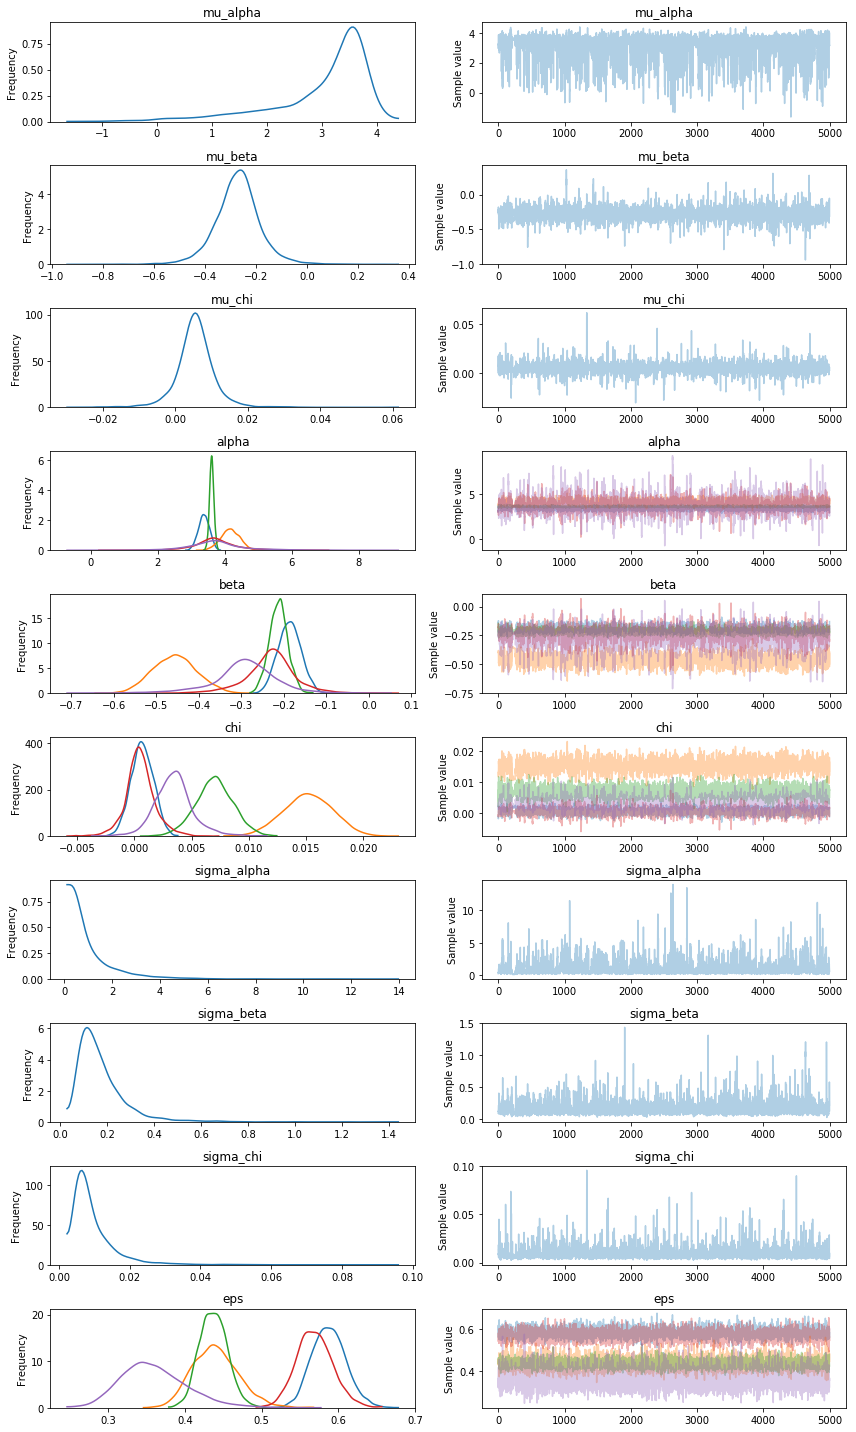

In [7]:
pm.traceplot(trace0)
plt.tight_layout()

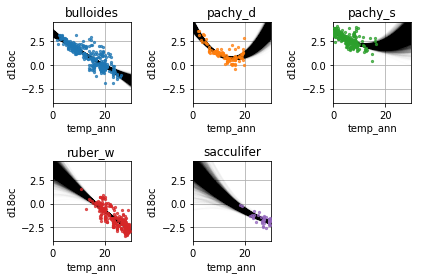

In [8]:
# Plot the simulations of fits for each spp.
synth_temp = np.arange(0, 31)
for i in np.unique(idx_species):
    spp = coretops.species.unique()[i]
    ax = plt.subplot(2, 3, i+1)
    spp_msk = coretops.species.unique() == spp
    y = trace0['alpha'][:, spp_msk] + trace0['beta'][:, spp_msk] * synth_temp + trace0['chi'][:, spp_msk] * synth_temp**2
    ax.plot(np.broadcast_to(synth_temp, (y.shape[0], len(synth_temp))).T, 
            y.T, alpha = 0.01, label=spp, 
            color='black')
    coretops.query("species == '{}'".format(spp)).plot(y='d18oc', x='temp_ann', 
        ax=ax, kind='scatter', marker='.', alpha=0.75, 
        color=list(matplotlib.colors.TABLEAU_COLORS.values())[i], zorder=10)
    ax.set_xlim(0, 30)
    ax.set_ylim(-4, 4.5)
    ax.set_title(spp)
    ax.grid(True)
plt.tight_layout()
plt.show()

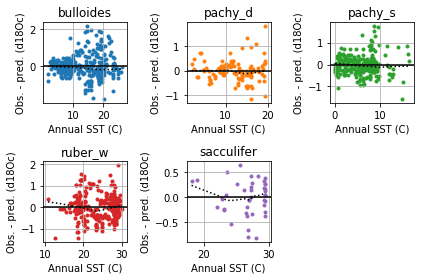

In [9]:
# Plot residuals of the median model for each spp.
for i in np.unique(idx_species):
    spp = coretops.species.unique()[i]
    coretops_sub = coretops.query("species == '{}'".format(spp))
    ax = plt.subplot(2, 3, i+1)
    spp_msk = coretops.species.unique() == spp
    alpha = np.median(trace0['alpha'][:, spp_msk])
    beta = np.median(trace0['beta'][:, spp_msk])
    chi = np.median(trace0['chi'][:, spp_msk])
    y = alpha + beta * coretops_sub['temp_ann'] + chi * coretops_sub['temp_ann'] **2
    resids = coretops_sub['d18oc'] - y
    resids_smoothed = sm.nonparametric.lowess(resids, coretops_sub['temp_ann'], frac=0.75)
    ax.plot(resids_smoothed[:, 0], resids_smoothed[:, 1], label='LOWESS', linestyle=':', color='black')

    ax.scatter(x=coretops_sub['temp_ann'], y=resids, marker='.', label=spp, 
               color=list(matplotlib.colors.TABLEAU_COLORS.values())[i])
    ax.axhline(y=0, color='black')
    ax.set_title(spp)
    ax.set_ylabel('Obs. - pred. (d18Oc)')
    ax.set_xlabel('Annual SST (C)')
    ax.grid(True)
plt.tight_layout()
plt.show()

## Cubic model, no isotopes

In [10]:

with pm.Model() as model0:

    # Hyperparameters
    mu_a = pm.Normal('mu_alpha', mu=0, sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)

    mu_b = pm.Normal('mu_beta', mu=0, sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)

    mu_c = pm.Normal('mu_chi', mu=0, sd=1)
    sigma_c = pm.HalfCauchy('sigma_chi', beta=1)

    mu_d = pm.Normal('mu_delta', mu=0, sd=1)
    sigma_d = pm.HalfCauchy('sigma_delta', beta=1)


    # Intercept and slope
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_species)
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=n_species)
    c = pm.Normal('chi', mu=mu_c, sd=sigma_c, shape=n_species)
    d = pm.Normal('delta', mu=mu_d, sd=sigma_d, shape=n_species)
    # Model error
    eps = pm.HalfCauchy('eps', beta=1, shape=n_species)

    # Likelihood
    # d18oc_est = a[idx_species] + b[idx_species] * coretops['temp_ann']
    d18oc_est = a[idx_species] + b[idx_species] * coretops['temp_ann'] + c[idx_species] * coretops['temp_ann']**2 + d[idx_species] * coretops['temp_ann']**3
    # d18oc_est = a[idx_species] + b[idx_species] * coretops['temp_ann'] + (coretops['d18osw'] - 0.27)
    # d18oc_est = a[idx_species] + b[idx_species] * coretops['temp_ann'] + c[idx_species] * coretops['temp_ann']**2  + (coretops['d18osw'] - 0.27)
    # d18oc_est = a[idx_species] + b[idx_species] * coretops['temp_ann'] + c[idx_species] * coretops['temp_ann']**2
    likelihood = pm.Normal('y', mu=d18oc_est, sd=eps[idx_species], 
                           observed=coretops['d18oc'])

    trace0 = pm.sample(5000, njobs=1)


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 2,090.7:  30%|███       | 60360/200000 [01:26<03:03, 761.53it/s]   
Convergence archived at 60400
Interrupted at 60,400 [30%]: Average Loss = 1.4092e+09
100%|██████████| 5500/5500 [1:18:58<00:00,  1.38it/s]/home/sbm/miniconda3/envs/deltaoxfox/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/home/sbm/miniconda3/envs/deltaoxfox/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 255 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



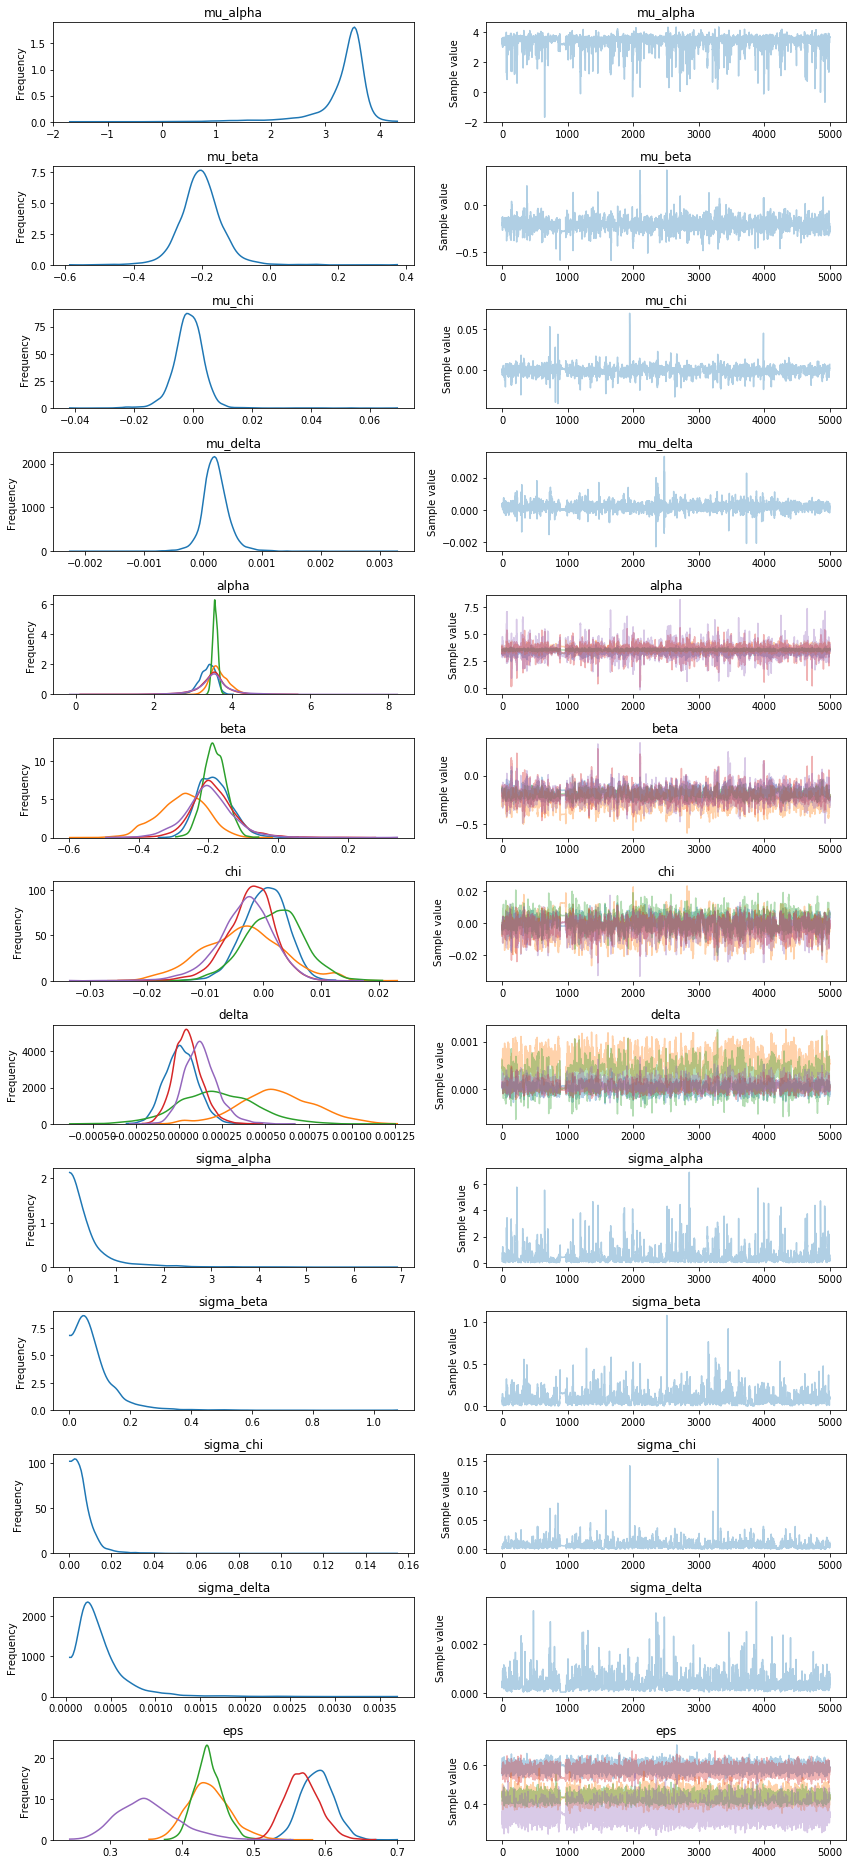

In [11]:
pm.traceplot(trace0)
plt.tight_layout()

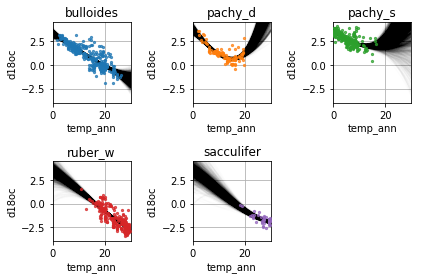

In [12]:
# Plot the simulations of fits for each spp.
synth_temp = np.arange(0, 31)
for i in np.unique(idx_species):
    spp = coretops.species.unique()[i]
    ax = plt.subplot(2, 3, i+1)
    spp_msk = coretops.species.unique() == spp
    # y = trace0['alpha'][:, spp_msk] + trace0['beta'][:, spp_msk] * synth_temp
    # y = trace0['alpha'][:, spp_msk] + trace0['beta'][:, spp_msk] * synth_temp + trace0['chi'][:, spp_msk] * synth_temp**2
    y = trace0['alpha'][:, spp_msk] + trace0['beta'][:, spp_msk] * synth_temp + trace0['chi'][:, spp_msk] * synth_temp**2 + trace0['delta'][:, spp_msk] * synth_temp**3
    ax.plot(np.broadcast_to(synth_temp, (y.shape[0], len(synth_temp))).T, 
            y.T, alpha = 0.01, label=spp, 
            color='black')
    coretops.query("species == '{}'".format(spp)).plot(y='d18oc', x='temp_ann', 
        ax=ax, kind='scatter', marker='.', alpha=0.75, 
        color=list(matplotlib.colors.TABLEAU_COLORS.values())[i], zorder=10)
    ax.set_xlim(0, 30)
    ax.set_ylim(-4, 4.5)
    ax.set_title(spp)
    ax.grid(True)
plt.tight_layout()
plt.show()

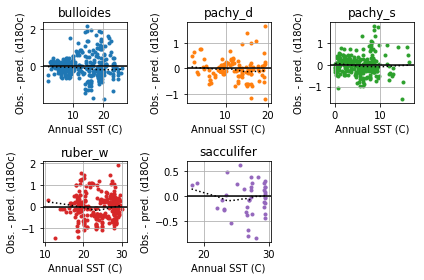

In [13]:
# Plot residuals of the median model for each spp.
for i in np.unique(idx_species):
    spp = coretops.species.unique()[i]
    coretops_sub = coretops.query("species == '{}'".format(spp))
    ax = plt.subplot(2, 3, i+1)
    spp_msk = coretops.species.unique() == spp
    alpha = np.median(trace0['alpha'][:, spp_msk])
    beta = np.median(trace0['beta'][:, spp_msk])
    chi = np.median(trace0['chi'][:, spp_msk])
    delta = np.median(trace0['delta'][:, spp_msk])
    # y = alpha + beta * coretops_sub['temp_ann']
    # y = alpha + beta * coretops_sub['temp_ann'] + (coretops_sub['d18osw'] - 0.27)
    # y = alpha + beta * coretops_sub['temp_ann'] + chi * coretops_sub['temp_ann'] **2
    y = alpha + beta * coretops_sub['temp_ann'] + chi * coretops_sub['temp_ann'] **2 + delta * coretops_sub['temp_ann'] **3
    resids = coretops_sub['d18oc'] - y
    resids_smoothed = sm.nonparametric.lowess(resids, coretops_sub['temp_ann'], frac=0.75)
    ax.plot(resids_smoothed[:, 0], resids_smoothed[:, 1], label='LOWESS', linestyle=':', color='black')

    ax.scatter(x=coretops_sub['temp_ann'], y=resids, marker='.', label=spp, 
               color=list(matplotlib.colors.TABLEAU_COLORS.values())[i])
    ax.axhline(y=0, color='black')
    ax.set_title(spp)
    ax.set_ylabel('Obs. - pred. (d18Oc)')
    ax.set_xlabel('Annual SST (C)')
    ax.grid(True)
plt.tight_layout()
plt.show()

## Non-Bayesian Gaussian Process model for *N. pachyderma* (dextral)

In [14]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

In [15]:
coretops_sub = coretops.query("species == 'pachy_d'")

In [16]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)

gp.fit(coretops_sub['temp_ann'].values[:, np.newaxis], coretops_sub['d18oc'].values[:, np.newaxis])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [17]:
gp.kernel_

1.89**2 + Matern(length_scale=7.36, nu=1.5) + WhiteKernel(noise_level=0.171)

In [18]:
synth_temp = np.arange(0, 31)
d18oc_pred, d18oc_sigma = gp.predict(synth_temp[:, np.newaxis], return_std=True)

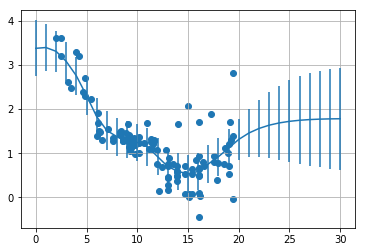

In [19]:
plt.scatter(x=coretops_sub['temp_ann'], y=coretops_sub['d18oc'], label='Observed')
plt.errorbar(x=synth_temp, y=d18oc_pred, yerr=d18oc_sigma)
plt.grid()